## Import libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import warnings
import datetime
import scipy.stats as stats
from scipy.stats import f_oneway 
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Data Preprocessing

### Load data and Redo the Processing that done in EDA

In [2]:
# Read the CSV file into a DataFrame(dfloan)
dfloan = pd.read_csv('../data/loan_data_2007_2014.csv', low_memory=False)

# Dropping unnecessary columns from the dataframe
dfloan = dfloan.drop(columns=['id', 'member_id', 'Unnamed: 0'], axis=1)

# Define a function to map loan status to 'Good Loan' or 'Bad Loan'
def map_loan_status(status):
    """
    Function to map loan status to 'Bad Loan' or 'Good Loan'.
    
    Parameters:
    status (str): The loan status to be mapped.
    
    Returns:
    str: 'Bad Loan' if the status is in the list of default statuses, 'Good Loan' otherwise.
    """
    
    # List of loan statuses that imply a default
    default_statuses = [
        'Charged Off', 
        'Late (31-120 days)', 
        'Late (16-30 days)',
        'Default',
        'Does not meet the credit policy. Status:Charged Off'
    ]
    
    # Return 'Bad Loan' if the status is in the list of default statuses, 'Good Loan' otherwise
    return 'Bad Loan' if status in default_statuses else 'Good Loan'

# Apply the map_loan_status function to each status in the 'loan_status' column
dfloan['loan_status'] = dfloan['loan_status'].apply(map_loan_status)

# Convert the 'issue_d' column to datetime format with 'Oct-14' style dates
dfloan['issue_d'] = pd.to_datetime(dfloan['issue_d'], format='%b-%y')

# Extract the year from the datetime object ad store it in a new column 'years'
dfloan['years'] = dfloan['issue_d'].dt.year


# Define a list of state abbreviations that belong to the West region
West = [
    'CA',  # California
    'NV',  # Nevada
    'UT',  # Utah
    'CO',  # Colorado
    'WY',  # Wyoming
    'MT',  # Montana
    'ID',  # Idaho
    'OR',  # Oregon
    'WA',  # Washington
    'AK',  # Alaska
    'HI'   # Hawaii
]

# Define a list of state abbreviations that belong to the Southwest region
Southwest = [
    'AZ',  # Arizona
    'NM',  # New Mexico
    'TX',  # Texas
    'OK'   # Oklahoma
]

# Define a list of state abbreviations that belong to the Midwest region
Midwest = [
    'ND',  # North Dakota
    'MN',  # Minnesota
    'SD',  # South Dakota
    'NE',  # Nebraska
    'KS',  # Kansas
    'MO',  # Missouri
    'IA',  # Iowa
    'WI',  # Wisconsin
    'IL',  # Illinois
    'IN',  # Indiana
    'OH',  # Ohio
    'MI'   # Michigan
]

# Define a list of state abbreviations that belong to the Southeast region
Southeast = [
    'AR',  # Arkansas
    'LA',  # Louisiana
    'MS',  # Mississippi
    'AL',  # Alabama
    'GA',  # Georgia
    'TN',  # Tennessee
    'KY',  # Kentucky
    'NC',  # North Carolina
    'SC',  # South Carolina
    'WV',  # West Virginia
    'DC',  # District of Columbia
    'VA',  # Virginia
    'DE',  # Delaware
    'FL'   # Florida
]

# Define a list of state abbreviations that belong to the Northeast region
Northeast = [
    'PA',  # Pennsylvania
    'MD',  # Maryland
    'NJ',  # New Jersey
    'NY',  # New York
    'CT',  # Connecticut
    'RI',  # Rhode Island
    'MA',  # Massachusetts
    'NH',  # New Hampshire
    'VT',  # Vermont
    'ME'   # Maine
]

def us_region(state):
    """
    Function to map US state to its corresponding region.

    Parameters:
    state (str): The US state abbreviation.

    Returns:
    str: The region where the state is located.
    """
    # Check if the state is in the West region
    if state in West:
        return 'West'
    # Check if the state is in the Southwest region
    elif state in Southwest:
        return 'Southwest'
    # Check if the state is in the Midwest region
    elif state in Midwest:
        return 'Midwest'
    # Check if the state is in the Southeast region
    elif state in Southeast:
        return 'Southeast'
    # Check if the state is in the Northeast region
    elif state in Northeast:
        return 'Northeast'
    # If the state is not in any of the defined regions, return 'Other'
    else:
        return 'Other'

# Apply the function us_region to 'addr_state' column
# This will create a new column 'region' in the dataframe dfloan
dfloan['region'] = dfloan['addr_state'].apply(us_region)

### Drop Columns with High Missing Values

In [3]:
def dropnan(data, threshold):
    """
    Function to drop columns with missing values above a certain threshold.
    
    Parameters:
    data (DataFrame): The data to be cleaned.
    threshold (float): The threshold proportion of missing values, columns above threshold which will be dropped.
    
    Returns:
    DataFrame: The cleaned data with columns dropped based on the threshold.

    Examples:
    >>> dropnan(dfloan, 0.5)
    """

    # Iterate over each column in the DataFrame
    for column in data.columns:
        
        # Calculate the proportion of missing values in the current column
        missing_values = data[column].isnull().sum() / len(data)

        # if the proportion of missing values is greatwer than the threshold
        if missing_values > threshold:
            
            # Drop the current column from the DataFrame
            data = data.drop(columns=column, axis=1)
    
    # Return the cleaned DataFrame
    return data

In [4]:
# Drop the columns with missing values above the threshold
dfloan_cleaned = dropnan(dfloan, 0.4)

print(dfloan.shape)
print(dfloan_cleaned.shape)

(466285, 74)
(466285, 52)


In [5]:
# potential_bin = ['delinq_2yrs', ]

### Drop Uneccessary Columns

In [6]:
not_necessary_col = ['sub_grade', 'emp_title', 'pymnt_plan', 'url', 'zip_code', 'title', 'addr_state',
                     'total_acc', 'out_prncp_inv','total_pymnt_inv', 'total_rec_late_fee', 
                     'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med',
                     'application_type', 'policy_code', 'acc_now_delinq', 'years']
dfloan_cleaned1 = dfloan_cleaned.drop(columns=not_necessary_col, axis=1)

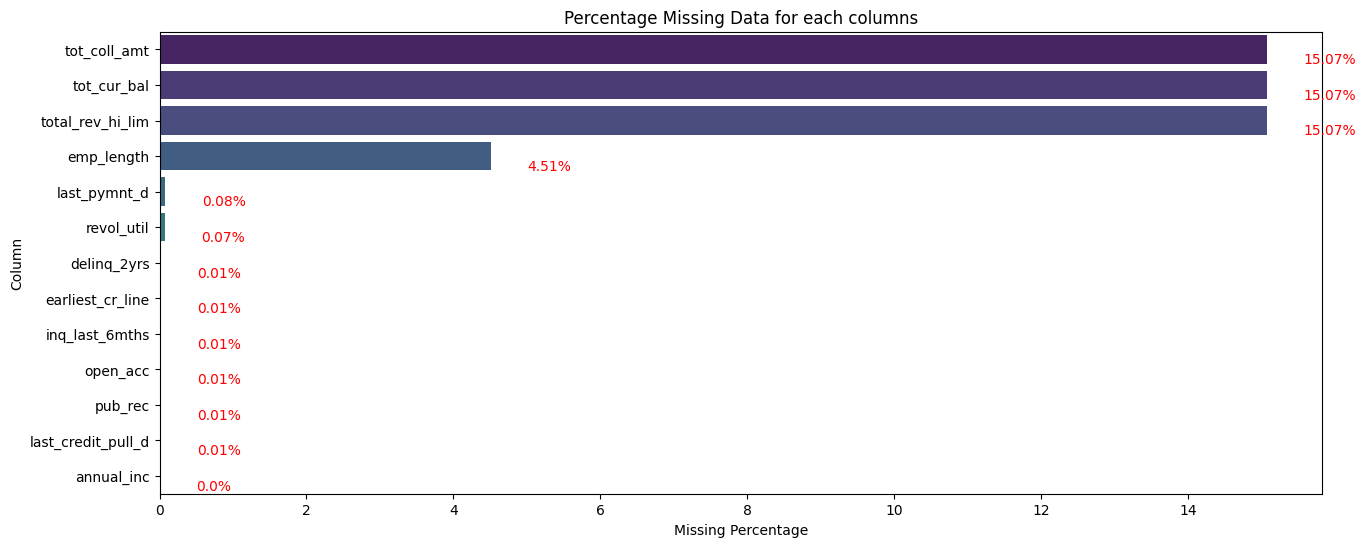

In [7]:
def plot_missing_value(data):
    # Calculate the percentage of missing values in each column
    missing = (data.isnull().sum() / len(data)) * 100
    
    # Filter out the columns that have no missing values
    missing = missing[missing>0]

    # Create a DataFrame from the missing data
    missing_data = pd.DataFrame({'Column': missing.index, 
                                 'Missing%': np.round(missing.values, 2)
    })

    # Sort the DataFrame by the percentage of missing values in descending order
    missing_data = missing_data.sort_values('Missing%', ascending=False)

    # Create a bar plot of the missing data
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x='Missing%', y='Column', data=missing_data, palette='viridis')

    # Add the percentage of missing data as text on the bars
    for i, v in enumerate(missing_data['Missing%']):
        ax.text(v + 0.5, i + .4, str(v) + '%', color='red')

    # Set the labels and title of the plot
    ax.set_xlabel('Missing Percentage')
    ax.set_title('Percentage Missing Data for each columns')

plot_missing_value(dfloan_cleaned1)


### Train Test Split

In [8]:
X = dfloan_cleaned1.drop(columns=['loan_status'])
y = dfloan_cleaned1[['loan_status']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1103)

print(f'X train shape: {X_train.shape}')
print(f'y train shape:{y_train.shape}')

print(f'\nX test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X train shape: (326399, 33)
y train shape:(326399, 1)

X test shape: (139886, 33)
y_test shape: (139886, 1)


### Impute rest of missing values

In [9]:
# define funtion to fill numerical missing values with median and categorical missing values with mode
def fillnan(data):
    """
    Function to fill missing values in a DataFrame. Numeric columns are filled with the median of the column,
    while categorical/non-numeric columns are filled with the mode.

    Parameters:
    data (DataFrame): The DataFrame to be cleaned.

    Returns:
    DataFrame: The cleaned DataFrame with missing values filled.

    Examples:
    >>> fillnan(data)

    """
    
    # Iterate over each column in the DataFrame
    for column in data.columns:

        # Check if the current column is numeric
        if data[column].dtype in ['int64', 'float64']:
            # Fill missing values with the median of the column
            data[column] = data[column].fillna(data[column].median())
        else:
            # Fill missing values with the mode of the column
            data[column] = data[column].fillna(data[column].mode()[0])
    # Return the cleaned DataFrame
    return data

# Fill missing values in the train set
X_train_clean = fillnan(X_train)

### Feature Selection

#### Chi Square Test for Categorical Columns

In [10]:
cat_select = X_train_clean.select_dtypes('object')

for column in cat_select.columns:
    contingency_table = pd.crosstab(X_train_clean[column], y_train['loan_status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p < 0.05:
        print(f'{column} is dependent on loan_status')
    else:
        print(f'{column} is independent on loan_status')

term is dependent on loan_status
grade is dependent on loan_status
emp_length is dependent on loan_status
home_ownership is dependent on loan_status
verification_status is dependent on loan_status
purpose is dependent on loan_status
earliest_cr_line is dependent on loan_status
initial_list_status is dependent on loan_status
last_pymnt_d is dependent on loan_status
last_credit_pull_d is dependent on loan_status
region is dependent on loan_status


#### Correlation Matrix for Numerical Columns

<Axes: >

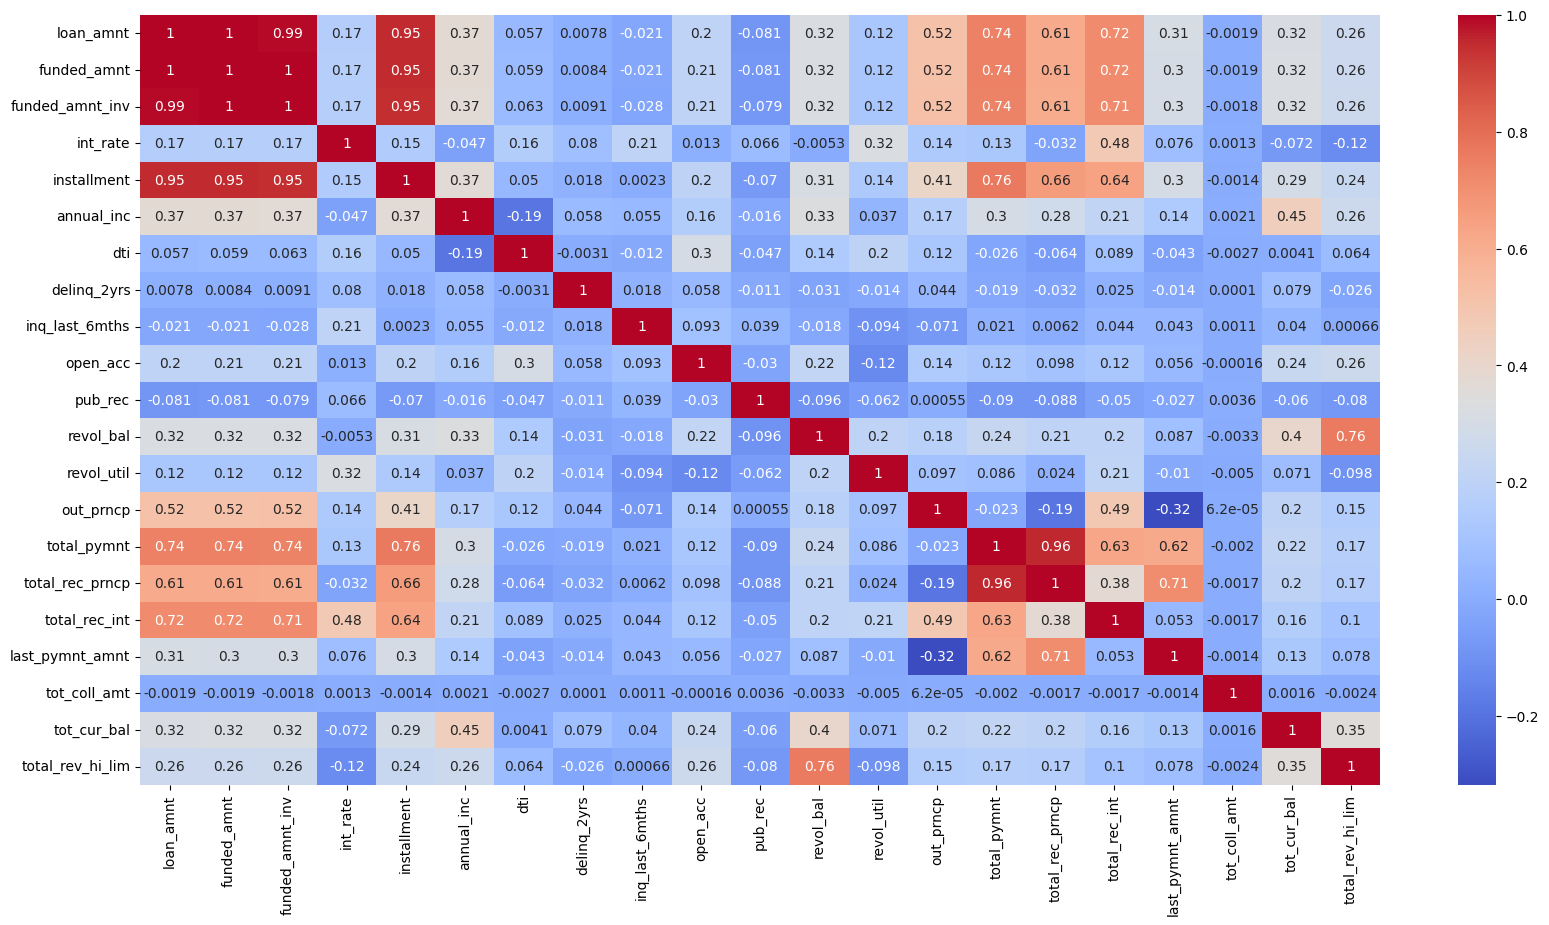

In [11]:
nums = X_train_clean.select_dtypes('number')

dfcorr = nums.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(dfcorr, cmap='coolwarm', annot=True)

In [12]:
# Drop multicollinearity columns
multi_col = ['loan_amnt', 'funded_amnt_inv', 'total_rec_int', 'total_pymnt', 'revol_bal']

X_train_nomulti = X_train_clean.drop(columns=multi_col, axis=1)

#### ANOVA Test for Numerical Columns

<Axes: xlabel='p_value', ylabel='column'>

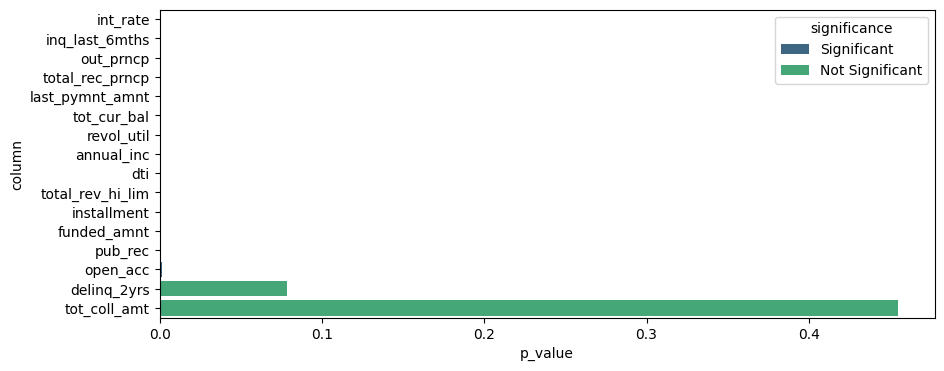

In [13]:
df_temp = pd.concat([X_train_nomulti, y_train], axis=1)
new_nums = df_temp.select_dtypes('number')

anova_results = pd.DataFrame(columns=['column', 'f_score', 'p_value', 'significance'])

# Perform ANOVA for each numerical column with respect to the target
for i, column in enumerate(new_nums.columns):
    # Separate the data based on the categories in the target
    good = df_temp[column][df_temp['loan_status'] == 'Good Loan']
    bad = df_temp[column][df_temp['loan_status'] == 'Bad Loan']
    
    # Perform the ANOVA test
    f_statistic, p_value = f_oneway(good, bad)

    # Determine the significance
    if p_value < 0.05:
        significance = 'Significant'
    else:
        significance = 'Not Significant'
    
    # Append the results to the DataFrame
    anova_results.loc[i] = [column, f_statistic, p_value, significance]

anova_results = anova_results.sort_values('p_value')

plt.figure(figsize=(10, 4))
sns.barplot(x='p_value', y='column', hue='significance', data=anova_results, palette='viridis')

`delinq_2yrs` and `tot_coll_amt` are not significant in ANOVA test, so we can drop them.

In [14]:
# Define a list of columns that are not significant for the model
not_sig = ['delinq_2yrs', 'tot_coll_amt']

# Drop the non-significant columns from the training data
X_train_selected = X_train_nomulti.drop(columns=not_sig, axis=1)

# Display a random sample of 3 rows from the modified training data
X_train_selected.sample(3)

,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_util,initial_list_status,out_prncp,total_rec_prncp,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,tot_cur_bal,total_rev_hi_lim,region
378845,10000,36 months,10.99,327.34,B,4 years,RENT,60000.0,Verified,2014-06-01,other,15.18,Aug-00,0.0,9.0,0.0,70.4,w,5131.53,4868.47,Jan-16,327.34,Jan-16,29672.0,17100.0,Northeast
193906,14675,36 months,14.33,503.92,C,10+ years,MORTGAGE,37524.0,Verified,2012-10-01,credit_card,11.80,Dec-91,1.0,7.0,0.0,74.2,f,0.00,14675.00,Aug-15,1504.10,Jan-16,261943.0,8100.0,Northeast
414093,3600,36 months,12.99,121.29,B,10+ years,MORTGAGE,135000.0,Not Verified,2014-04-01,debt_consolidation,16.28,Aug-01,2.0,13.0,0.0,73.7,f,0.00,3600.00,Aug-14,3386.63,Jan-16,435358.0,11800.0,Southeast


In [15]:
X = dfloan_cleaned1.drop(columns=['loan_status'])
y = dfloan_cleaned1[['loan_status']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1103)

X_train_clean = fillnan(X_train)

# Drop multicollinearity columns
multi_col = ['loan_amnt', 'funded_amnt_inv', 'total_rec_int', 'total_pymnt', 'revol_bal']

X_train_nomulti = X_train_clean.drop(columns=multi_col, axis=1)

not_sig = ['delinq_2yrs', 'tot_coll_amt']
X_train_selected = X_train_nomulti.drop(columns=not_sig, axis=1)

### Cap Outliers

In [16]:
# Define function to cap outliers
def cap_outliers(data, cols):
    """
    Function to cap outliers in a DataFrame.

    Parameters:
    data (DataFrame): The DataFrame to be cleaned.
    cols (List): The list of columns to cap outliers in.

    Returns:
    DataFrame: The cleaned DataFrame with outliers capped.

    Examples:
    >>> cap_outliers(X_train, outlier_cols)

    """

    # Iterate over each column in the DataFrame
    for column in cols:
        # Calculate the first quartile
        Q1 = data[column].quantile(0.25)
        # Calculate the third quartile
        Q3 = data[column].quantile(0.75)
        # Calculate the interquartile range
        IQR = Q3 - Q1
        # Calculate the lower bound
        lower_bound = Q1 - 1.5 * IQR
        # Calculate the upper bound
        upper_bound = Q3 + 1.5 * IQR
        # Cap the outliers
        data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
        data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])

    return data

In [17]:
# Define a list of columns that have outliers
outliers = ['annual_inc', 'inq_last_6mths', 'open_acc', 'revol_util']

# Use the 'cap_outliers' function to handle outliers in the training data
# The function caps the outliers in the specified columns of the DataFrame
X_train_noutlier = cap_outliers(X_train_selected, outliers)

# Display a random sample of 3 rows from the modified training data
X_train_noutlier.sample(3)

,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_util,initial_list_status,out_prncp,total_rec_prncp,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,tot_cur_bal,total_rev_hi_lim,region
382272,7000,36 months,10.99,229.14,B,10+ years,OWN,58000.0,Source Verified,2014-05-01,credit_card,10.01,Oct-01,2.0,9.0,1.0,25.0,f,0.0,7000.0,Jun-14,7064.11,Jul-14,14633.0,9900.0,Southwest
124831,11000,36 months,12.12,365.99,B,6 years,MORTGAGE,55000.0,Not Verified,2013-06-01,debt_consolidation,25.27,Dec-98,0.0,20.0,0.0,43.1,f,0.0,3521.6,Jul-14,365.99,Dec-14,217903.0,45991.0,Southeast
76338,20000,60 months,12.99,454.96,B,8 years,MORTGAGE,54000.0,Verified,2013-10-01,debt_consolidation,20.00,Nov-00,0.0,12.0,0.0,47.7,w,0.0,20000.0,Sep-15,14334.79,Oct-15,139168.0,29400.0,Northeast


### Further Feature Engineering

#### Feature Creation

In [18]:
# Create a copy of the selected features for further feature engineering
X_train_eng = X_train_noutlier.copy()

# Define a function to convert a date column into two new columns
def days_month_converter(data, date_col):
    """
    This function converts a date column into two new columns:
    1. days_since_{date_col}: Number of days from the date to the current date.
    2. {date_col}_month: The month of the date.

    Parameters:
    data (DataFrame): The DataFrame containing the date column.
    date_col (str): The name of the date column to convert.

    Returns:
    DataFrame: The updated DataFrame with the new columns and the original date column dropped.

    Examples:
    >>> days_month_converter(dfloan_cleaned, 'issue_d')
    """

    # Convert the date column to datetime format
    data[date_col] = pd.to_datetime(data[date_col], format='%b-%y')

    # Get the current date
    current_date = datetime.datetime.now()

    # Create a new column for the number of days from the date to the current date
    data[f"days_since_{date_col}"] = (current_date - data[date_col]).dt.days

    # Create a new column for the month of the date
    data[f"{date_col}_month"] = data[date_col].dt.month

    # Drop the original date column
    data = data.drop(columns=date_col, axis=1)

    return data

# List of date columns to convert
dates = ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d']

# Convert the date columns in the list to days and month columns
for date in dates:
   X_train_eng = days_month_converter(X_train_eng, date)


# For 'pub_rec' column, if the value is greater than 0, replace it with 'no', otherwise replace it with 'yes'
X_train_eng['pub_rec'] = X_train_eng['pub_rec'].apply(lambda x: 'no' if x > 0 else 'yes')

# Create a mapping for 'initial_list_status' column
map_istatus = {
    'f': 'fractional',
    'w': 'whole'
}

# Apply the mapping to 'initial_list_status' column
X_train_eng['initial_list_status'] = X_train_eng['initial_list_status'].map(map_istatus)

# Create a mapping for 'home_ownership' column
map_home = {
    'NONE': 'OTHER'  # Map 'NONE' to 'OTHER'
}

# Apply the mapping to 'home_ownership' column
X_train_eng['home_ownership'] = X_train_eng['home_ownership'].replace(map_home)

# Display a random sample of 3 rows from the modified training data
X_train_eng.sample(3)

,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,inq_last_6mths,open_acc,pub_rec,revol_util,initial_list_status,out_prncp,total_rec_prncp,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,region,days_since_earliest_cr_line,earliest_cr_line_month,days_since_issue_d,issue_d_month,days_since_last_pymnt_d,last_pymnt_d_month,days_since_last_credit_pull_d,last_credit_pull_d_month
423750,3000,36 months,14.64,103.47,C,< 1 year,MORTGAGE,50000.00,Not Verified,home_improvement,11.43,0.0,9.0,yes,44.2,fractional,1410.41,1589.59,103.47,162979.0,21800.0,Midwest,7517,9,3683,3,3012,1,3012,1
167433,24000,36 months,7.62,747.88,A,10+ years,MORTGAGE,90000.00,Verified,debt_consolidation,16.04,0.0,12.0,yes,90.7,fractional,754.84,23245.16,747.88,173831.0,37800.0,Midwest,10896,6,4076,2,3012,1,3012,1
261528,3000,36 months,14.31,102.99,C,10+ years,RENT,49756.32,Source Verified,debt_consolidation,18.26,0.0,13.0,yes,84.5,whole,1982.45,1017.55,102.99,16966.0,11200.0,West,10774,10,3438,11,3012,1,3012,1


#### Feature Encoding

In [19]:
# create a copy of X_train
X_train_enc = X_train_eng.copy()

# List of columns to be one-hot encoded
col_to_ohe = X_train_enc.select_dtypes('object').columns

# Perform one-hot encoding on each column in the list
for column in col_to_ohe:
    # Create dummy variables for each unique category in the column
    dummies = pd.get_dummies(X_train_enc[column], prefix=f'{column}:').astype(int)
    
    # Concatenate the dummy variables with the original DataFrame
    X_train_enc = pd.concat([X_train_enc, dummies], axis=1)
    
    # Drop the original column from the DataFrame
    X_train_enc.drop(columns=column, axis=1, inplace=True)


# Define a mapping for 'loan_status' column values
map_target = {
    'Good Loan': 0,  # Map 'Good Loan' to 0
    'Bad Loan': 1    # Map 'Bad Loan' to 1
}

# Apply the mapping to the target train and test
y_train['loan_status'] = y_train['loan_status'].map(map_target)

# Display encoded training data shape, a random sample of 3 rows and target
print(X_train_enc.shape)
display(X_train_enc.sample(3))
display(y_train.sample(3))

(326399, 71)


,funded_amnt,int_rate,installment,annual_inc,dti,inq_last_6mths,open_acc,revol_util,out_prncp,total_rec_prncp,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,days_since_earliest_cr_line,earliest_cr_line_month,days_since_issue_d,issue_d_month,days_since_last_pymnt_d,last_pymnt_d_month,days_since_last_credit_pull_d,last_credit_pull_d_month,term:_ 36 months,term:_ 60 months,grade:_A,grade:_B,grade:_C,grade:_D,grade:_E,grade:_F,grade:_G,emp_length:_1 year,emp_length:_10+ years,emp_length:_2 years,emp_length:_3 years,emp_length:_4 years,emp_length:_5 years,emp_length:_6 years,emp_length:_7 years,emp_length:_8 years,emp_length:_9 years,emp_length:_< 1 year,home_ownership:_MORTGAGE,home_ownership:_OTHER,home_ownership:_OWN,home_ownership:_RENT,verification_status:_Not Verified,verification_status:_Source Verified,verification_status:_Verified,purpose:_car,purpose:_credit_card,purpose:_debt_consolidation,purpose:_educational,purpose:_home_improvement,purpose:_house,purpose:_major_purchase,purpose:_medical,purpose:_moving,purpose:_other,purpose:_renewable_energy,purpose:_small_business,purpose:_vacation,purpose:_wedding,pub_rec:_no,pub_rec:_yes,initial_list_status:_fractional,initial_list_status:_whole,region:_Midwest,region:_Northeast,region:_Southeast,region:_Southwest,region:_West
277009,10000,14.49,344.17,70000.0,25.97,2.0,7.0,16.3,0.0,10000.00,7500.69,32753.0,17100.0,12296,8,3469,10,3104,10,3104,10,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
420683,6000,10.99,196.41,45350.0,28.74,2.0,13.0,51.2,0.0,6000.00,3295.89,32368.0,8400.0,7974,6,3683,3,3104,10,3073,11,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
389890,13000,10.15,420.39,45000.0,25.57,0.0,5.0,99.3,0.0,3903.46,420.39,41308.0,11900.0,7882,9,3622,5,3226,6,3012,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0


,loan_status
183,1
370405,0
266693,0


### Feature Scaling

In [20]:
# Select numerical columns from the DataFrame, excluding 'pub_rec'
num_scale = X_train_eng.select_dtypes('number')

# Initialize a StandardScaler
scaler = StandardScaler()

# Scale the numerical columns and convert the result into a DataFrame
X_scale = pd.DataFrame(scaler.fit_transform(num_scale))

# Assign the original column names to the scaled DataFrame
X_scale.columns = num_scale.columns

# Drop the numerical columns from the encoded DataFrame
X_train_catenc = X_train_enc.drop(columns=num_scale.columns)

# Make sure the indices of the encoded DataFrame match with the original DataFrame
X_train_catenc.index = X_train_selected.index
X_scale.index = X_train_selected.index

# Concatenate the scaled numerical DataFrame and the encoded categorical DataFrame
X_train_scaled = pd.concat([X_scale, X_train_catenc], axis=1)

# Display scaled training data shape and a random sample of 3 rows
print(X_train_scaled.shape)
display(X_train_scaled.sample(3))

(326399, 71)


,funded_amnt,int_rate,installment,annual_inc,dti,inq_last_6mths,open_acc,revol_util,out_prncp,total_rec_prncp,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,days_since_earliest_cr_line,earliest_cr_line_month,days_since_issue_d,issue_d_month,days_since_last_pymnt_d,last_pymnt_d_month,days_since_last_credit_pull_d,last_credit_pull_d_month,term:_ 36 months,term:_ 60 months,grade:_A,grade:_B,grade:_C,grade:_D,grade:_E,grade:_F,grade:_G,emp_length:_1 year,emp_length:_10+ years,emp_length:_2 years,emp_length:_3 years,emp_length:_4 years,emp_length:_5 years,emp_length:_6 years,emp_length:_7 years,emp_length:_8 years,emp_length:_9 years,emp_length:_< 1 year,home_ownership:_MORTGAGE,home_ownership:_OTHER,home_ownership:_OWN,home_ownership:_RENT,verification_status:_Not Verified,verification_status:_Source Verified,verification_status:_Verified,purpose:_car,purpose:_credit_card,purpose:_debt_consolidation,purpose:_educational,purpose:_home_improvement,purpose:_house,purpose:_major_purchase,purpose:_medical,purpose:_moving,purpose:_other,purpose:_renewable_energy,purpose:_small_business,purpose:_vacation,purpose:_wedding,pub_rec:_no,pub_rec:_yes,initial_list_status:_fractional,initial_list_status:_whole,region:_Midwest,region:_Northeast,region:_Southeast,region:_Southwest,region:_West
49010,-1.002089,-0.224961,-0.946101,-1.014911,-1.406714,0.319934,-0.665006,-1.902297,-0.366095,-0.704233,-0.526815,-0.549722,-0.090178,0.858925,-0.800977,-0.227704,1.482286,-0.647426,-0.958874,-0.419805,-0.544727,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0
803,-0.277260,0.674536,-0.023603,-0.955752,0.522342,-0.839672,-0.234868,1.111504,-0.693814,0.444015,0.904344,-0.343957,-0.173658,-0.846964,0.359634,1.445149,1.482286,2.006651,-0.501991,-0.419805,-0.544727,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
99738,1.217702,-1.654517,1.297935,2.505057,-0.076111,0.319934,2.130890,-1.543511,-0.693814,2.202031,2.827141,1.453094,1.229343,-0.239344,1.230093,0.051486,0.276195,0.759030,0.411776,-0.419805,-0.544727,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0


### Resample Data

In [21]:
smot = SMOTE(random_state=1103)

X_train_ovr, y_train_ovr = smot.fit_resample(X_train_scaled, y_train)

print(f"Target before Resampled:\n{y_train.value_counts()}")
print(f"\nTarget after Resampled:\n{y_train_ovr.value_counts()}")

Target before Resampled:
loan_status
0              289916
1               36483
Name: count, dtype: int64

Target after Resampled:
loan_status
0              289916
1              289916
Name: count, dtype: int64


### Update all the processing to data Test
(Handle missing values & Feature encoding only)

In [22]:
X_test_clean = fillnan(X_test)

X_test_nomulti = X_test_clean.drop(columns=multi_col, axis=1)

X_test_selected = X_test_nomulti.drop(columns=not_sig, axis=1)

X_test_eng = X_test_selected.copy()

# Convert the date columns in the list to days and month columns
for date in dates:
   X_test_eng = days_month_converter(X_test_eng, date)

X_test_eng['pub_rec'] = X_test_eng['pub_rec'].apply(lambda x: 'no' if x == 0 else 'yes')

X_test_eng['initial_list_status'] = X_test_eng['initial_list_status'].map(map_istatus)

map_home = {
    'NONE': 'OTHER',  # Map 'NONE' to 'OTHER'
    'ANY': 'OTHER' # Map 'ANY' to 'OTHER'
}

# Apply the mapping to the 'home_ownership' column
X_test_eng['home_ownership'] = X_test_eng['home_ownership'].replace(map_home)

# create a copy of X_train
X_test_enc = X_test_eng.copy()

# List of columns to be one-hot encoded
col_to_ohe = X_test_enc.select_dtypes('object').columns

# Perform one-hot encoding on each column in the list
for column in col_to_ohe:
    # Create dummy variables for each unique category in the column
    dummies = pd.get_dummies(X_test_enc[column], prefix=f'{column}:').astype(int)
    
    # Concatenate the dummy variables with the original DataFrame
    X_test_enc = pd.concat([X_test_enc, dummies], axis=1)
    
    # Drop the original column from the DataFrame
    X_test_enc.drop(columns=column, axis=1, inplace=True)

# Apply the mapping to the target train and test
y_test['loan_status'] = y_test['loan_status'].map(map_target)

#Display a random sample of 3 rows from the preprocessed test data and target
print(X_test_enc.shape)
display(X_test_enc.sample(3))
display(y_test.sample(3))

(139886, 71)


,funded_amnt,int_rate,installment,annual_inc,dti,inq_last_6mths,open_acc,revol_util,out_prncp,total_rec_prncp,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,days_since_earliest_cr_line,earliest_cr_line_month,days_since_issue_d,issue_d_month,days_since_last_pymnt_d,last_pymnt_d_month,days_since_last_credit_pull_d,last_credit_pull_d_month,term:_ 36 months,term:_ 60 months,grade:_A,grade:_B,grade:_C,grade:_D,grade:_E,grade:_F,grade:_G,emp_length:_1 year,emp_length:_10+ years,emp_length:_2 years,emp_length:_3 years,emp_length:_4 years,emp_length:_5 years,emp_length:_6 years,emp_length:_7 years,emp_length:_8 years,emp_length:_9 years,emp_length:_< 1 year,home_ownership:_MORTGAGE,home_ownership:_OTHER,home_ownership:_OWN,home_ownership:_RENT,verification_status:_Not Verified,verification_status:_Source Verified,verification_status:_Verified,purpose:_car,purpose:_credit_card,purpose:_debt_consolidation,purpose:_educational,purpose:_home_improvement,purpose:_house,purpose:_major_purchase,purpose:_medical,purpose:_moving,purpose:_other,purpose:_renewable_energy,purpose:_small_business,purpose:_vacation,purpose:_wedding,pub_rec:_no,pub_rec:_yes,initial_list_status:_fractional,initial_list_status:_whole,region:_Midwest,region:_Northeast,region:_Southeast,region:_Southwest,region:_West
72521,15000,18.55,546.44,93900.0,25.81,1.0,20.0,59.5,5026.89,9973.11,546.44,30755.0,38800.0,7579,7,3834,10,3012,1,3012,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
274701,12000,11.67,396.69,70000.0,4.99,0.0,8.0,1.6,0.00,12000.00,11852.53,34361.0,12100.0,11261,6,3469,10,3408,12,3196,7,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
367324,15850,14.49,545.50,55000.0,26.53,0.0,11.0,77.0,8338.17,7511.83,545.50,209797.0,21600.0,8825,2,3591,6,3012,1,3012,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0


,loan_status
462389,0
98498,0
65138,0


### Modeling Logistic Regression
Because in this Final Task Logistic Regression is the main focus, so I will use Logistic Regression as the main model.

In [23]:
# lr = LogisticRegression(random_state=1103)

# def evaluate_model(model, X_train, y_train, X_test, y_test, threshold):
#     model.fit(X_train, y_train)

#     train_pred = model.predict_proba(X_train)[:, 1]
#     test_pred = model.predict_proba(X_test)[:, 1]

#     # print the score with the roc auc score
#     train_auc = roc_auc_score(y_train, train_pred)
#     test_auc = roc_auc_score(y_test, test_pred)
#     print(f"Train AUC: {train_auc}")
#     print(f"Test AUC: {test_auc}")

#     train_recall = recall_score(y_train, train_pred > threshold)
#     test_recall = recall_score(y_test, test_pred > threshold)
#     print(f"Train Recall: {train_recall}")
#     print(f"Test Recall: {test_recall}")

#     train_precision = precision_score(y_train, train_pred > threshold)
#     test_precision = precision_score(y_test, test_pred > threshold)
#     print(f"Train Precision: {train_precision}")
#     print(f"Test Precision: {test_precision}")

#     train_f1 = f1_score(y_train, train_pred > threshold)
#     test_f1 = f1_score(y_test, test_pred > threshold)
#     print(f"Train F1: {train_f1}")
#     print(f"Test F1: {test_f1}")

    

In [24]:
# Assuming X is your new dataset

X_clean = fillnan(X)

X_nomulti = X_clean.drop(columns=multi_col, axis=1)

X_selected = X_nomulti.drop(columns=not_sig, axis=1)

X_eng = X_selected.copy()

# Convert the date columns in the list to days and month columns
for date in dates:
   X_eng = days_month_converter(X_eng, date)

X_eng['pub_rec'] = X_eng['pub_rec'].apply(lambda x: 'no' if x == 0 else 'yes')

X_eng['initial_list_status'] = X_eng['initial_list_status'].map(map_istatus)

map_home = {
    'NONE': 'OTHER',  # Map 'NONE' to 'OTHER'
    'ANY': 'OTHER' # Map 'ANY' to 'OTHER'
}

# Apply the mapping to the 'home_ownership' column
X_eng['home_ownership'] = X_eng['home_ownership'].replace(map_home)

# create a copy of X
X_enc = X_eng.copy()

# List of columns to be one-hot encoded
col_to_ohe = X_enc.select_dtypes('object').columns

# Perform one-hot encoding on each column in the list
for column in col_to_ohe:
    # Create dummy variables for each unique category in the column
    dummies = pd.get_dummies(X_enc[column], prefix=f'{column}:').astype(int)
    
    # Concatenate the dummy variables with the original DataFrame
    X_enc = pd.concat([X_enc, dummies], axis=1)
    
    # Drop the original column from the DataFrame
    X_enc.drop(columns=column, axis=1, inplace=True)

# Assuming y is your target variable for the new dataset
# Apply the mapping to the target
y['loan_status'] = y['loan_status'].map(map_target)

#### Define function to Evaluate Model

In [25]:
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold):
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_pred_proba = model.predict_proba(X_train)[:, 1]  
    test_pred_proba = model.predict_proba(X_test)[:, 1]

    # print the score with the roc auc score
    train_auc = roc_auc_score(y_train, train_pred_proba)
    test_auc = roc_auc_score(y_test, test_pred_proba)

    train_recall = recall_score(y_train, train_pred_proba > threshold)
    test_recall = recall_score(y_test, test_pred_proba > threshold)

    train_precision = precision_score(y_train, train_pred_proba > threshold)
    test_precision = precision_score(y_test, test_pred_proba > threshold)

    train_f1 = f1_score(y_train, train_pred_proba > threshold)
    test_f1 = f1_score(y_test, test_pred_proba > threshold)

    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1103)
    cv_score = cross_val_score(model, X_enc, y, cv=skf, scoring='roc_auc')

    scoredict = {
        'Model': 'LogisticRegression', 
        'AUC_train': [train_auc], 
        'AUC_test': [test_auc],
        'Recall_train': [train_recall],
        'Recall_test': [test_recall],
        'Precision_train': [train_precision],
        'Precision_test': [test_precision],
        'F1_train': [train_f1], 
        'F1_test': [test_f1],
        'CrossVal_AUC': [cv_score.mean()]
    }

    df_eval = pd.DataFrame(scoredict)
    
    display(df_eval)

    # score = cross_validate(model, X_enc, y, cv=5, scoring='roc_auc', return_train_score=True)
    # print('ROC-AUC (crossval train):' + str(score['train_score']))
    # print('Mean ROC-AUC (crossval train):' + str(score['train_score'].mean()))
    # print('ROC-AUC (crossval test):' + str(score['test_score']))
    # print('Mean ROC-AUC (crossval test):' + str(score['test_score'].mean()))

In [32]:
# Define a function to plot AUC-ROC curve
def plot_roc_curve(model, X_train, y_train, X_test, y_test):
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Get the predicted probabilities on the test data
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate the fpr, tpr and threshold
    fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)

    # Calculate the AUC
    auc = roc_auc_score(y_test, y_pred_proba)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

#### Train and Evaluate Model 

In [26]:
lr = LogisticRegression(random_state=1103)

evaluate_model(lr, X_train_ovr, y_train_ovr, X_test_enc, y_test, 0.5)

,Model,AUC_train,AUC_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,CrossVal_AUC
0,LogisticRegression,0.997336,0.766718,0.972326,0.973381,0.999153,0.218105,0.985557,0.35636,0.955076


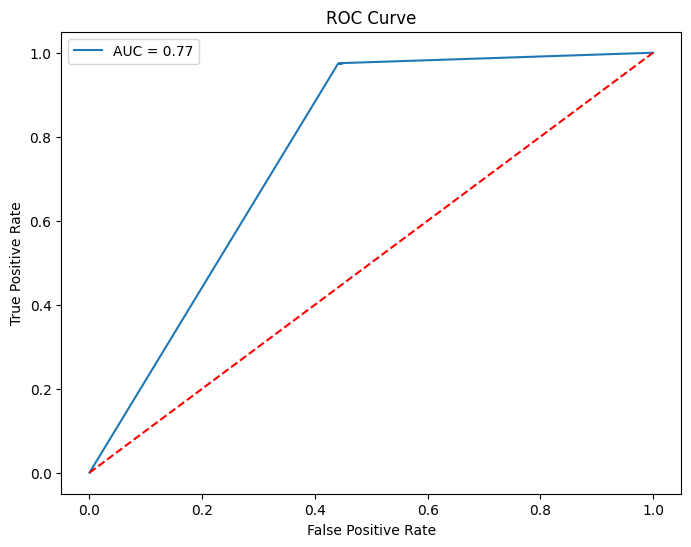

In [33]:
plot_roc_curve(lr, X_train_ovr, y_train_ovr, X_test_enc, y_test)

seems like our model is overfitting, as we can see that the f1 test score is lower than f1 train score.<br>
Let's try to tune the model using hyperparameter tuning.

### Logistic Regression Hyperparameter Tuning

In [32]:
# Define parameters to tune the model
param_grid = {
    'C': np.linspace(0.001, 1, 100),
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cholesky', 'saga', 'sag']
}

# Initialize the GridSearchCV object with 5-fold cross-validation
ranscv = RandomizedSearchCV(lr, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the GridSearchCV object to the data
ranscv.fit(X_train_ovr, y_train_ovr)

# Get the best parameters and the best score
best_params = ranscv.best_params_
best_score = ranscv.best_score_

# Display the best parameters and the best score
print('Best Parameters:', best_params)
print('Best Score:', best_score)

In [35]:
# Display the best parameters and the best score
print('Best Parameters:', best_params)
print('Best Score:', best_score)

Best Parameters: {'solver': 'newton-cholesky', 'penalty': 'l2', 'C': 0.4248181818181818}
Best Score: 0.9964153923983352


In [34]:
lrn = LogisticRegression(**best_params, random_state=1103)

evaluate_model(lrn, X_train_ovr, y_train_ovr, X_test_enc, y_test, 0.5)

,Model,AUC_train,AUC_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,CrossVal_AUC
0,LogisticRegression,0.997297,0.803016,0.971368,0.946189,0.999202,0.258535,0.985088,0.406106,0.955207


after parameter tuning with RandomizedSearchCV, the model performance just a little bit better than the previous model.<br>
let's try to manual tuning the model.

In [30]:
param_dict = {
    'C': 0.01, # smaller values specify stronger regularization
    'penalty': 'l2',
    'random_state': 1103
} # we don't need to specify the solver like newton-cholesky or saga because the default is fine

lr_tuned = LogisticRegression(**param_dict)

evaluate_model(lr_tuned, X_train_ovr, y_train_ovr, X_test_enc, y_test, 0.4) # i use 0.4 as the threshold because this threshold gives more stable between recall and precision

,Model,AUC_train,AUC_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,CrossVal_AUC
0,LogisticRegression,0.996587,0.862138,0.967149,0.718525,0.994439,0.998849,0.980604,0.835809,0.955188


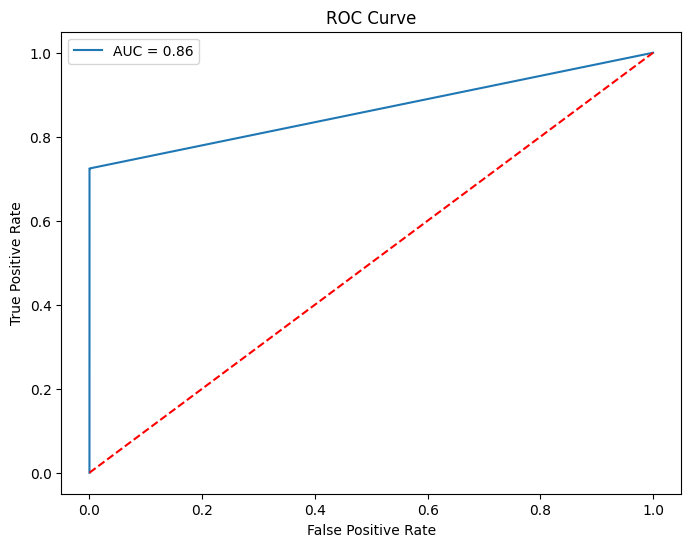

In [34]:
plot_roc_curve(lr_tuned, X_train_ovr, y_train_ovr, X_test_enc, y_test)

Seems like the precision test is too high, let's try to tune the model again(especially the C parameter).

In [38]:
param_dict = {
    'C': 0.05, # tune up the reguralization value
    'penalty': 'l2',
    'random_state': 1103
} # we don't need to specify the solver like newton-cholesky or saga because the default is fine

lr_tuned2 = LogisticRegression(**param_dict)

evaluate_model(lr_tuned2, X_train_ovr, y_train_ovr, X_test_enc, y_test, 0.4)

,Model,AUC_train,AUC_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,CrossVal_AUC
0,LogisticRegression,0.997046,0.899689,0.970153,0.804114,0.997344,0.913345,0.983561,0.855256,0.955042


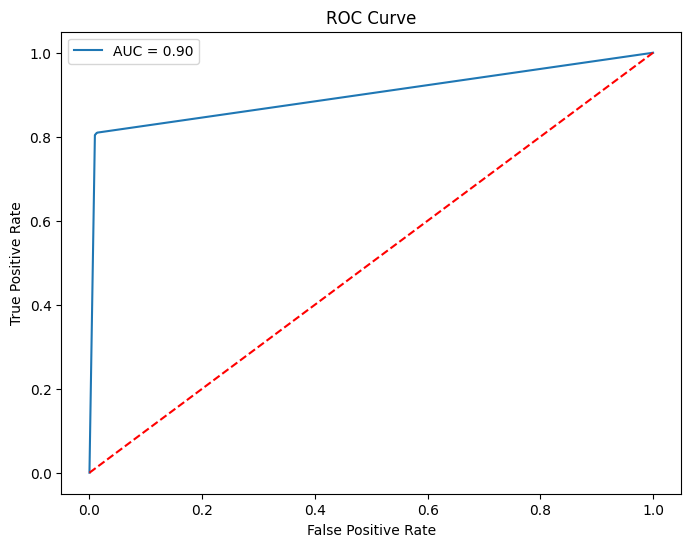

In [39]:
plot_roc_curve(lr_tuned2, X_train_ovr, y_train_ovr, X_test_enc, y_test)

that's better, now this lr_tuned2 is my final Logistic Regression model... Let's take a look at the feature importance and the confusion matrix.

### Tuned Logistic Regression Confusion Matrix & Feature Importance

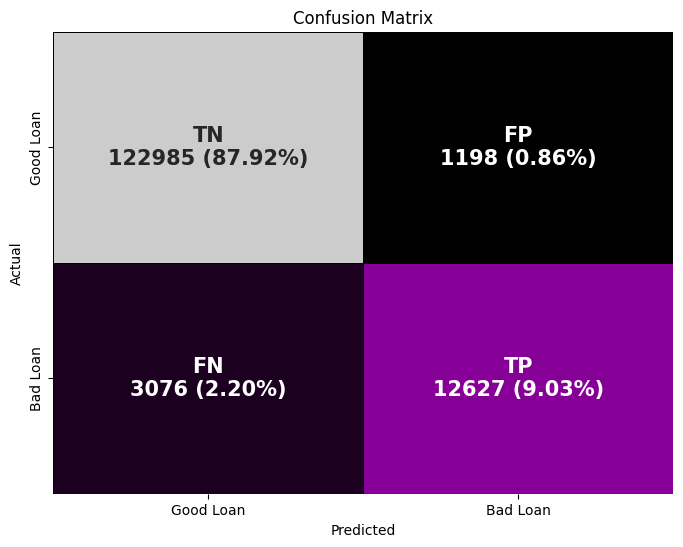

In [93]:
# Plot the confusion matrix
def plot_confusion_matrix(model, X_test, y_test, threshold):
    # Get the predicted probabilities on the test data
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate the predicted values based on the threshold
    y_pred = (y_pred_proba > threshold)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate the percentage of each value in the confusion matrix
    cm_perc = cm / cm.sum()

    # Define the labels
    labels = np.array([['TN', 'FP'],
                       ['FN', 'TP']])
    
    # Create labels with the percentage values
    labels = (np.asarray(["{0}\n{1} ({2:.2%})".format(label, value, percentage)
                              for label, value, percentage in zip(labels.flatten(), cm.flatten(), cm_perc.flatten())])
                 ).reshape(2,2)

    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=labels, 
        fmt='', 
        cmap='nipy_spectral', 
        cbar=False, 
        annot_kws={'size': 15, 'weight': 'bold'}, 
        linewidths=0.5, 
        linecolor='black', 
        xticklabels=['Good Loan', 'Bad Loan'], 
        yticklabels=['Good Loan', 'Bad Loan']
    
    )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(lr_tuned2, X_test_enc, y_test, 0.4)

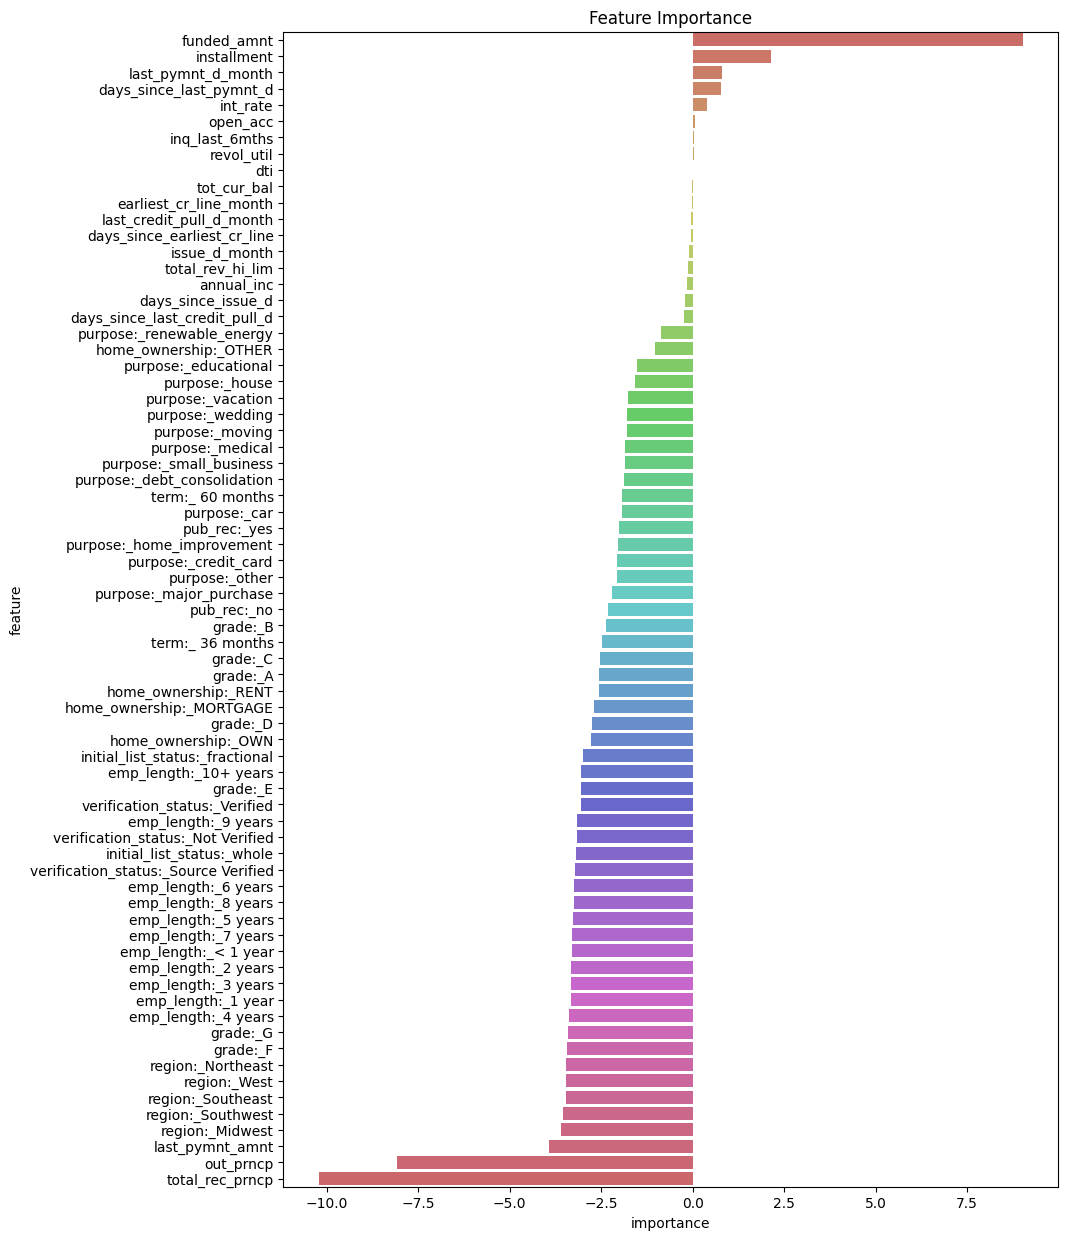

In [47]:
# Fit the Logistic Regression model to data so we can get the feature importances
feature_importance = pd.DataFrame({'feature': X_train_enc.columns, 'importance': lr_tuned2.coef_[0]})

# Sort the DataFrame by importance in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)

# plot the feature importance
plt.figure(figsize=(10, 15))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='hls')
plt.title('Final LR Feature Importance')
plt.show()

### Other Models 

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=1103)

evaluate_model(xgb, X_train_ovr, y_train_ovr, X_test_enc, y_test, 0.5)

In [51]:
lr = LogisticRegression(random_state=1103, max_iter=1000, penalty='l2', C=0.1)

evaluate_model(lr, X_train_ovr, y_train_ovr, X_test_enc, y_test, 0.5)

,Model,AUC_train,AUC_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,CrossVal_AUC
0,LogisticRegression,0.994344,0.81875,0.95339,0.881488,0.97918,0.311666,0.966113,0.46051,0.966364


In [ ]:
Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test	CrossVal_AUC
0	LogisticRegression	0.994344	0.81875	0.95339	0.881488	0.97918	0.311666	0.966113	0.46051	0.966364

In [ ]:
Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test	CrossVal_AUC
0	LogisticRegression	0.994614	0.781144	0.955732	0.932115	0.97958	0.241332	0.967509	0.383398	0.955225

In [ ]:
Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test	CrossVal_AUC
0	LogisticRegression	0.982187	0.73175	0.816956	0.985162	0.972018	0.192473	0.887767	0.32203	0.981983

In [ ]:
Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test
0	LogisticRegression	0.994614	0.781148	0.92166	0.932115	0.995652	0.241332	0.957228	0.383398

#### Hyperparameter Tuning

In [38]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1103)
evaluate_model(rf, X_train_ovr, y_train_ovr, X_test_enc, y_test, 0.5)

In [24]:
# # with solver = saga
# Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test	CrossVal_AUC
# 0	LogisticRegression	0.995689	0.820767	0.922398	0.6323	0.999137	1.0	0.959235	0.774735	0.91346

# Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test	CrossVal_AUC
# 0	LogisticRegression	0.996587	0.862138	0.942211	0.718525	0.999704	0.998849	0.970106	0.835809	0.955188

# 	Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test	CrossVal_AUC
# 0	LogisticRegression	0.995689	0.820767	0.986789	0.6323	0.913779	1.0	0.948882	0.774735	0.91346

# Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test	CrossVal_AUC
# 0	LogisticRegression	0.996576	0.86084	0.98384	0.71585	0.93966	0.999022	0.961243	0.834057	0.980793

# Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test	CrossVal_AUC
# 0.996587	0.862138	0.983809	     0.718525	0.939903	     0.998849	    0.961355	0.835809	0.955188